## Import and Preprocessing

We import Yelp business data from our trimmed `cleaned.csv` file.

For further processing, we only analyze American cities for now. Since this particular dataset has data from only one metropolitan area in each state, we don't need to look up MSA information on a per-city basis for now.

Our data cleaning is rather light for now:
* We filter any restaurant with the name 'Airport' since airport restaurants don't compete with local restaurants.
* We filter any business with too many categories (2 standard deviations above mean), since they are likely to be falsely labeled as restaurants.

To-do:
* Shorten the 'Event Planning & Service' string to just 'Event Planning' for display space.
* Scrub out more fake restaurants.

In [15]:
from collections import Counter
from ast import literal_eval
import pandas as pd
import numpy as np

# import and cleaning
rests = pd.read_csv('cleaned.csv')
rests['categories'] = rests['categories'].apply(literal_eval)

# American cities only
rests = rests[rests['state'].isin(['PA', 'NC', 'IL', 'AZ', 'NV', 'WI', 'OH'])]

# add metropolitan data
rests = rests.assign(metro=df['state'].map({'PA': 'Pittsburgh',
                                      'NC': 'Charlotte',
                                      'IL': 'Urbana-Champaign',
                                      'AZ': 'Phoenix',
                                      'NV': 'Las Vegas',
                                      'WI': 'Madison',
                                      'OH': 'Cleveland'}))

# light cleaning
rests = rests[~rests['name'].str.contains('Airport')]

rests['cat_length'] = rests['categories'].apply(len)
# mean + 2 * std = 7.89
rests = rests[rests['cat_length'] < 8]

## Data Analysis

We define four functions to perform our data analysis:

`categorize(df, n)` takes an input DataFrame `df` of restaurants and creates a DataFrame of categories.
* The 'Restaurant' and 'Food' categories are deleted.
* We only return categories with `n` restaurants.
* Future: Create groupings of categories (i.e. 'Tex-Mex' versus 'Mexican') for finer analysis.

`cat_score(df, category, plot)` scores all of the restaurants in a given `df` and `category`.
* Individual restaurants are scored using the `score` function.
* A box plot of the individual restaurant scores is also created if `plot=True` is passed.
* The category score is the sum of the individual restaurant scores.

`analyze_metro(m)` returns a DataFrame of categories and category scores from the metropolitan area `m`.
* Future: We also compute ratio of restaurant count in the metropolitan versus in the nation.

`score(df)` creates a score of all restaurants in the passed DataFrame `df`.
* The current scoring function is square of average rating * the percentage share of total reviews by the restaurant.
* When summed, categories are scored by a square average of average rating, weighted by number of reviews.

In [35]:
def categorize(df, n):
    # creates a categories DataFrame from input dataframe, taking categories with over n restaurants
    df_cats = pd.DataFrame.from_dict(Counter(df['categories'].sum()), orient='index') \
        .reset_index().rename(columns={'index': 'category', 0: 'restaurant_count'})

    # delete categories 'Restaurants' and 'Food'
    df_cats = df_cats[(df_cats['category'] != 'Restaurants') & (df_cats['category'] != 'Food')]

    # a more complete method would be to cluster categories
    # as proof of concept, we'll just take the top ones for now
    return df_cats[df_cats['restaurant_count'] >= n]


def cat_score(df, category, plot):
    # searches input DataFrame for restaurants in given category
    cat_search = df[df['categories'].apply(lambda x: category in x)]
    
    # compute individual restaurant scores
    cat_search = cat_search.assign(score=score(cat_search))
    
    # plots scores if plot = True
    if plot: cat_search['score'].plot(kind='box')
    
    # return the category score
    return np.sqrt(cat_search['score'].sum())


def analyze_metro(m):
    # creates data for city restaurants and categories
    city_rests = rests[rests['metro'] == m]
    city_cats = categorize(city_rests, 0)

    # merge this categorical data with our original analysis
    city_cats = pd.merge(city_cats, cats, how='right', on=['category']).fillna(0)

    # find the ratio of restaurant_count in given metro versus the dataset, normalize by max
    city_cats['ratio'] = city_cats['restaurant_count_x'].div(city_cats['restaurant_count_y']) * rests.size / city_rests.size

    # return scored categories in the metro
    return city_cats.assign(score=city_cats['category'].apply(lambda x: cat_score(city_rests, x, False))) \
        .set_index('category')


def score(df):
    # creates a score series based on input category-city dataframe
    # current score metric: square of average rating * percent share of ratings
    return (df['stars'] ** 2) * df['review_count'] / df['review_count'].sum()

## Scoring

For now, we choose categories with at least 350 restaurants in the nation. We create a DataFrame called `scores` which uses the metropolitan areas as its index, and the chosen categories as its columns.

We fill the competitiveness scores of each category, by metropolitan area, and translate so each city has the same average score. Then, each category has its own scores (within the city) normalized. Finally, we create some plots of the restaurants of the least competitive categories.

In [36]:
# take categories with 350+ restaurants
cats = categorize(rests, 350)

scores = pd.DataFrame(index=rests['metro'].unique(), columns=cats['category'])

for metro in scores.index:
    metro_scores = analyze_metro(metro)['score']
    scores.loc[metro] = metro_scores

# normalize so each city has the same average category score
# adjust for behavior in each city
scores = scores.sub(scores.mean(axis=1), axis=0) + scores.mean().mean()

# normalize by mean, divide by standard deviation - for each category
# for each category, compare score to the nationwide average
scores_std = (scores - scores.mean()) / scores.std()

<IPython.core.display.Javascript object>


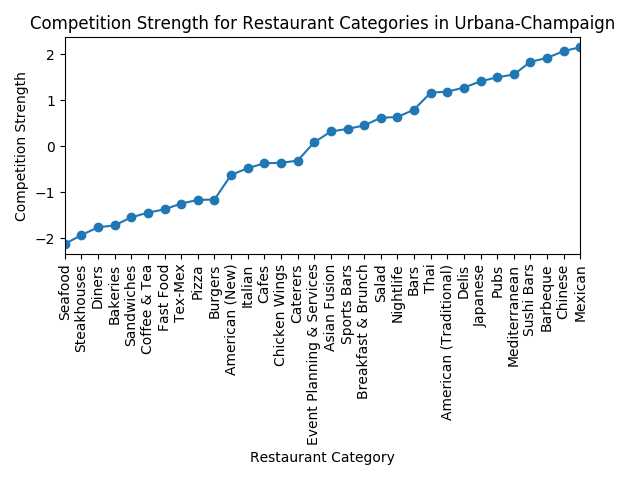

<IPython.core.display.Javascript object>


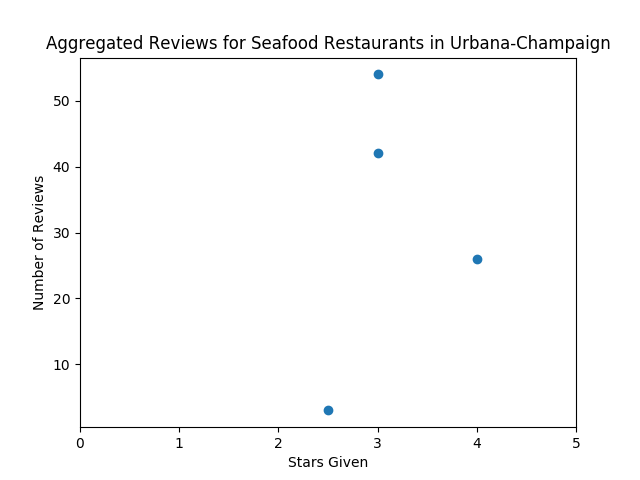

In [32]:
from matplotlib import pyplot as plt
%matplotlib notebook

def plot_score(df_score, city):
    # creates a bar chart of category scores in given city from input scores dataframe
    plt.figure()
    df_sorted = df_score.loc[city].sort_values()
    score_title = 'Competition Strength for Restaurant Categories in ' + city
    score_plot = df_sorted.plot(legend=False, title=score_title, style='o-',
                                xticks=np.arange(len(scores.columns)), rot=90)
    score_plot.set(xlabel = 'Restaurant Category', ylabel = 'Competition Strength')
    score_plot.set_xticklabels(df_sorted.index)
    plt.tight_layout()
    return score_plot


def category_plot(cat, city):
    city_data = df[df['metro'] == city]
    cat_list = city_data[city_data['categories'].apply(lambda x: cat in x)]
    cat_title = 'Aggregated Reviews for ' + cat + ' Restaurants in ' + city
    cat_plot = cat_list.plot(x=['stars'], y=['review_count'], style='o', xlim=(0, 5),
                             legend=False, title=cat_title)
    cat_plot.set(xlabel='Stars Given', ylabel='Number of Reviews')
    return cat_plot

plot_score(scores_std, 'Urbana-Champaign')
category_plot('Seafood', 'Urbana-Champaign')